# Demo

In this notebook, we'll give a simple demonstration of how to compute the estimated mean adjacency matrix for a dense multigraph, and evaluate the fit. In addition to the standard packages and files in this repository, you'll also need to place `hypergraph.py` (available [here](https://github.com/PhilChodrow/hypergraph)) in the `scripts` directory. Running this notebook can take a few minutes depending on your hardware. 

The code corresponding to the core mathematical contribution of the paper is contained in the functions `opt.compute_b()` and `opt.W_from_b()`. All that's needed to use these functions is a degree sequence. Everything else in this notebook is about generating the degree sequence and evaluating the fit. 

In [1]:
import networkx as nx
import numpy as np
from scripts import hypergraph, opt
from scripts.utils import experiment, degree_sort, adjacency_matrix
from matplotlib import pyplot as plt

# Construct Synthetic Data

28 degeneracies removed, 0 remain.


Text(0.5, 1.0, 'Degree Sequence')

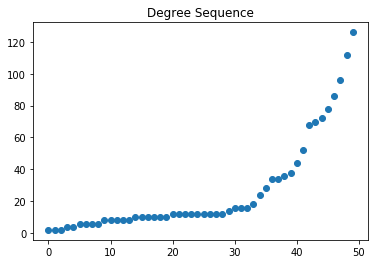

In [2]:
# construct a degree sequence

n = 50  # number of nodes

deg = (np.random.rand(n)*3)**5
deg += np.random.randint(1, n/2, n)
deg = deg / 4
deg = deg.astype(int) + 1
deg = deg * 2

# use nx.configuration model to make a multigraph, then represent as hypergraph
g = nx.configuration_model(deg)
e = list(g.edges())

G = hypergraph.hypergraph(e)
G.remove_degeneracy()        # remove self-loops
d = G.node_degrees()

plt.scatter(np.arange(n), np.sort(d))
plt.title('Degree Sequence')

# Compute Two Estimators

Next we'll compute the CL estimator 

$$ \hat{\omega}^0_{ij} = \frac{d_id_j}{\sum_\ell d_\ell}$$

and the estimator from the text: 

$$ \hat{\omega}^1_{ij} = \frac{\hat{\chi}_{ij}}{1 - \hat{\chi}_{ij}}\;,$$

where 

$$\hat{\chi}_{ij} = \frac{\hat{\beta}_i \hat{\beta}_j}{\sum_\ell \hat{\beta}_\ell}$$

In [3]:
# Chung-Lu Estimator

w0 = np.outer(d, d)/d.sum()
np.fill_diagonal(w0, 0)

In [4]:
# Our estimator

b = opt.compute_b(d)
w1 = opt.W_from_b(b)

round 0, current error = 1559.4
round 1, current error = 25.8558
round 2, current error = 1.5986
round 3, current error = 0.0346
round 4, current error = 0.0169


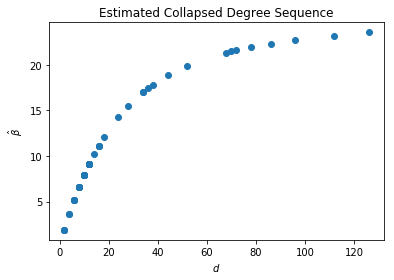

In [5]:
# b vs. d

plt.scatter(d, b)
plt.xlabel(r'$d$')
labs = plt.ylabel(r'$\hat{\beta}$')
t = plt.title('Estimated Collapsed Degree Sequence')

# Run Experiment

Next we compare these estimators against an unbiased approximation of the ground truth, $\hat{\omega}^{\text{MC}}$. Computing this estimator can take some time. 

In [6]:
n_steps = round(G.m*np.log(G.m))
w, x, w2 = experiment(G, n_stub = 0, 
                      n_vertex = n_steps/10, 
                      n_rounds = 1000, 
                      sample_after = 500, 
                      message_every = 10000)

Completed stub-labeled MCMC with 0 steps.
Round 0 of 1500 completed, 0 steps taken, acceptance rate = 0.1942


Now we'll compute and visualize the relative errors of each approximation. 

In [7]:
def rel_err(w, w_hat):
    err = (w_hat - w)/w 
    err[np.isinf(err)] = np.nan
    return(err)
    
def MARE(w, w_hat):
    return(np.nanmean(np.abs(rel_err(w, w_hat))))

In [8]:
print('The MARE of the CL estimator is ' + str(round(MARE(w, w0), 3)) + '.')
print('The MARE of the new estimator is ' + str(round(MARE(w, w1), 3)) + '.')

The MARE of the CL estimator is 0.343.
The MARE of the new estimator is 0.11.


/home/phil/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


It's useful to look at these matrices in order to see where the estimates diverge. 

/home/phil/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


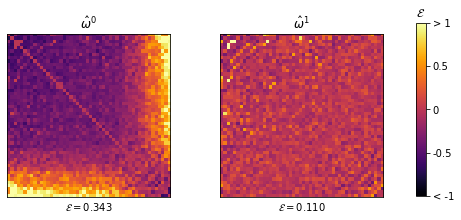

In [12]:
def rel_err_plot(w, w_hat, ax, vmin = -1, vmax = 1):
    err = rel_err(w, w_hat)
    err = degree_sort(err, d)
    np.fill_diagonal(err, 0)
    im = ax.imshow(err, cmap = 'inferno', vmin = vmin, vmax = vmax)
    
    ax.tick_params(
        which='both',      
        bottom=False,      
        top=False,         
        right=False,
        left=False,
        labelbottom=False,
        labelleft=False,
        length = 0)
    
    v = MARE(w, w_hat)
    err_message = r"$\mathcal{E} = $" + "{:05.3F}".format(v)
    
    ax.set(xlabel = err_message)
    
    return(im)


vmin = -1
vmax = 1

fig = plt.figure(figsize = (7, 3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
im1 = rel_err_plot(w, w0, ax1, vmin, vmax)
im2 = rel_err_plot(w, w1, ax2, vmin, vmax)

cbar_ax = fig.add_axes([0.95, 0.13, 0.02, 0.80])
cbar = fig.colorbar(im1, cax=cbar_ax, ticks=[vmin, vmin/2, 0, vmax/2, vmax])

ax1.set(title = r'$\hat{\omega}^0$')
ax2.set(title = r'$\hat{\omega}^1$')

cbar.ax.set_yticklabels(['< ' + str(vmin), str(vmin/2), '0' , str(vmax/2), '> ' + str(vmax)])  # vertically oriented colorbar
t = cbar_ax.set(title = r'$\mathcal{E}$')

The error in $\hat{\omega}^0$ is due in large part to estimation bias -- connections between nodes of similar degree are underestimated and connections between nodes of very different degrees are overestimated. In contrast, the error in $\hat{\omega}^1$ does not appear to display any systematic bias and is mostly due to noise in the simulation estimator. In the manuscript, a longer-running simulation reduces the error to around 2%. 